In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl

from scipy.linalg import expm
from scipy.signal import savgol_filter
from scipy import stats

import os
import pickle

In [3]:
# import opensim_ipython as osim

# import sys
# # Are we running this script as a test? Users can ignore this line!
# running_as_test = True  #'unittest' in str().join(sys.argv)

# # Define global model where the arm lives.
# arm = osim.Model()
# if not running_as_test: arm.setUseVisualizer(True)

# # ---------------------------------------------------------------------------
# # Create two links, each with a mass of 1 kg, centre of mass at the body's
# # origin, and moments and products of inertia of zero.
# # ---------------------------------------------------------------------------

# humerus = osim.Body("humerus",
#                     1.0,
#                     osim.Vec3(0, 0, 0),
#                     osim.Inertia(0, 0, 0))
# radius = osim.Body("radius",
#                    1.0,
#                    osim.Vec3(0, 0, 0),
#                    osim.Inertia(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Connect the bodies with pin joints. Assume each body is 1m long.
# # ---------------------------------------------------------------------------

# shoulder = osim.PinJoint("shoulder",
#                          arm.getGround(), # PhysicalFrame
#                          osim.Vec3(0, 0, 0),
#                          osim.Vec3(0, 0, 0),
#                          humerus, # PhysicalFrame
#                          osim.Vec3(0, 1, 0),
#                          osim.Vec3(0, 0, 0))

# elbow = osim.PinJoint("elbow",
#                       humerus, # PhysicalFrame
#                       osim.Vec3(0, 0, 0),
#                       osim.Vec3(0, 0, 0),
#                       radius, # PhysicalFrame
#                       osim.Vec3(0, 1, 0),
#                       osim.Vec3(0, 0, 0))

# # ---------------------------------------------------------------------------
# # Add a muscle that flexes the elbow (actuator for robotics people).
# # ---------------------------------------------------------------------------

# biceps = osim.Millard2012EquilibriumMuscle("biceps",  # Muscle name
#                                            200.0,  # Max isometric force
#                                            0.6,  # Optimal fibre length
#                                            0.55,  # Tendon slack length
#                                            0.0)  # Pennation angle
# biceps.addNewPathPoint("origin",
#                        humerus,
#                        osim.Vec3(0, 0.8, 0))

# biceps.addNewPathPoint("insertion",
#                        radius,
#                        osim.Vec3(0, 0.7, 0))

# # ---------------------------------------------------------------------------
# # Add a controller that specifies the excitation of the muscle.
# # ---------------------------------------------------------------------------

# brain = osim.PrescribedController()
# brain.addActuator(biceps)
# brain.prescribeControlForActuator("biceps",
#                                   osim.StepFunction(0.5, 3.0, 0.3, 1.0))

# # ---------------------------------------------------------------------------
# # Build model with components created above.
# # ---------------------------------------------------------------------------

# arm.addBody(humerus)
# arm.addBody(radius)
# arm.addJoint(shoulder) # Now required in OpenSim4.0
# arm.addJoint(elbow)
# arm.addForce(biceps)
# arm.addController(brain)

# # ---------------------------------------------------------------------------
# # Add a console reporter to print the muscle fibre force and elbow angle.
# # ---------------------------------------------------------------------------

# # We want to write our simulation results to the console.
# reporter = osim.ConsoleReporter()
# reporter.set_report_time_interval(1.0)
# reporter.addToReport(biceps.getOutput("fiber_force"))
# elbow_coord = elbow.getCoordinate().getOutput("value")
# reporter.addToReport(elbow_coord, "elbow_angle")
# arm.addComponent(reporter)

# # ---------------------------------------------------------------------------
# # Add display geometry. 
# # ---------------------------------------------------------------------------

# bodyGeometry = osim.Ellipsoid(0.1, 0.5, 0.1)
# bodyGeometry.setColor(osim.Gray)
# humerusCenter = osim.PhysicalOffsetFrame()
# humerusCenter.setName("humerusCenter")
# humerusCenter.setParentFrame(humerus)
# humerusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# humerus.addComponent(humerusCenter)
# humerusCenter.attachGeometry(bodyGeometry.clone())

# radiusCenter = osim.PhysicalOffsetFrame()
# radiusCenter.setName("radiusCenter")
# radiusCenter.setParentFrame(radius)
# radiusCenter.setOffsetTransform(osim.Transform(osim.Vec3(0, 0.5, 0)))
# radius.addComponent(radiusCenter)
# radiusCenter.attachGeometry(bodyGeometry.clone())

# # ---------------------------------------------------------------------------
# # Configure the model.
# # ---------------------------------------------------------------------------

# state = arm.initSystem()
# # Fix the shoulder at its default angle and begin with the elbow flexed.
# shoulder.getCoordinate().setLocked(state, True)
# elbow.getCoordinate().setValue(state, 0.5 * osim.SimTK_PI)
# arm.equilibrateMuscles(state)

# # ---------------------------------------------------------------------------
# # Simulate.
# # ---------------------------------------------------------------------------

# manager = osim.Manager(arm)
# state.setTime(0)
# manager.initialize(state)
# state = manager.integrate(10.0)

# # ---------------------------------------------------------------------------
# # Print/save model file
# # ---------------------------------------------------------------------------

# arm.printToXML("SimpleArm.osim")

[info] 'biceps' Parameter update for the damped-model: ActiveForceLengthCurve minimum value was 0.1 but is now 0.0.
[reporter]
              | /forceset/bice|               | 
          time| ps|fiber_force|    elbow_angle| 
--------------| --------------| --------------| 
           0.0|       1.180969|      1.5707963| 
           1.0|      57.467961|     0.77115447| 
           2.0|      15.410317|      1.5677076| 
           3.0|      55.051324|      1.4420497| 
           4.0|        34.1381|      1.5084833| 
           5.0|      33.369184|       1.517958| 
           6.0|      38.348794|       1.502133| 
           7.0|      34.935407|       1.507222| 
           8.0|      34.727737|      1.5079815| 
           9.0|      37.450975|       1.506801| 
          10.0|      35.401389|      1.5071367| 


True

In [4]:
filepath = "~/user-in-the-box/output/log_one_policy_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log.pickle"
filepath = "~/user-in-the-box/output/state_log.pickle"

with open(os.path.expanduser(filepath), "rb") as f:
    data = pickle.load(f)


In [5]:
def project_trajectory(trajectory, init_val=None, final_val=None):
    if init_val is None:
        init_val = trajectory[0]
    if final_val is None:
        final_val = trajectory[-1]
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    proj_vector = final_val - init_val
    proj_vector /= np.linalg.norm(proj_vector)**2  #normalize vector to project on
    
    projected_trajectory = np.array([np.dot(state_vec - init_val, proj_vector) for state_vec in trajectory])
    return projected_trajectory

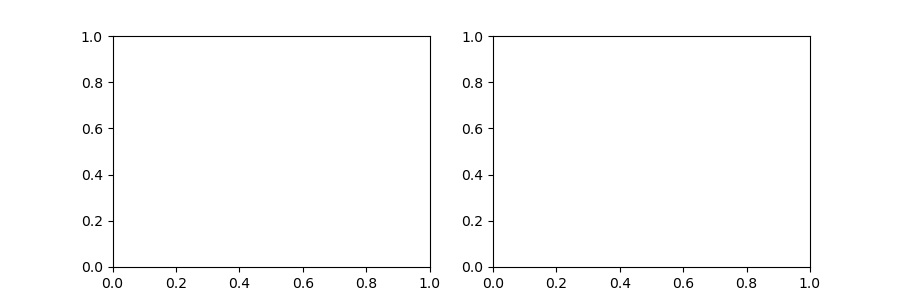

In [6]:
if "endeffector_fig" in locals():
    plt.close(endeffector_fig)
# endeffector_fig = plt.figure()
# endeffector_ax = endeffector_fig.gca()
endeffector_fig, endeffector_ax = plt.subplots(1, 2, figsize=[9, 3])

In [132]:
for axis in endeffector_ax:
    axis.clear()
endeffector_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.26, hspace=0.2)

####
EPISODE_ID = "009".zfill(3 + ("100episodes" not in filepath) and ("state_log" not in filepath))
NORMALIZE_TIME = True
MINJERK_USER_CONSTRAINTS = True
####

time_per_step = np.diff(data[f"episode_{EPISODE_ID}"]["timestep"]).mean()  #0.01
indices = np.append(np.insert(np.where(data[f"episode_{EPISODE_ID}"]["target_hit"])[0], 0, 0), len(data[f"episode_{EPISODE_ID}"]["target_hit"]))
if len(indices) <= 2:  #recompute indices based on switches in target position
    indices = np.where(np.diff(np.squeeze(data[f"episode_{EPISODE_ID}"]["target_position"]), axis=0).sum(axis=1))[0] + 1
assert len(indices) > 2
    
position_series = data[f"episode_{EPISODE_ID}"]["fingertip_xpos"]
velocity_series = data[f"episode_{EPISODE_ID}"]["fingertip_xvelp"]

# recover end-effector position time series [only for corrupted pickle file]
if filepath.endswith("log.pickle") or filepath.endswith("log_one_policy_100episodes_100Hz.pickle"):
    position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
    position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
    position_series += data[f"episode_{EPISODE_ID}"]["target_position"][indices[1] - 1] - position_series[indices[1] - 1] #ensure that target is reached at target hit/switch time

#velocity_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = time_per_step)).values
acceleration_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = time_per_step)).values

solid_line = Line2D([0], [0], color='black', linestyle='-', label='Simulation Data')
dashed_line = Line2D([0], [0], color='black', linestyle='--', label='MinJerk Trajectory')
endeffector_ax[0].legend(handles=[solid_line, dashed_line])

test = {}
for last_idx, current_idx, next_idx in list(zip([-1] + indices, indices, indices[1:]))[:6]:
    time_series_shifted = np.array(data[f"episode_{EPISODE_ID}"]["timestep"][current_idx: next_idx]) - data[f"episode_{EPISODE_ID}"]["timestep"][current_idx]
    if NORMALIZE_TIME:
        time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
    
    ## ANALYZE POSITION
    # apply Savitzky Golay Filter
    init_val=data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0]
    final_val=data[f"episode_{EPISODE_ID}"]["target_position"][current_idx] #or position_series[next_idx - 1]
    projected_trajectory = project_trajectory(position_series[current_idx: next_idx], init_val=data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], final_val=data[f"episode_{EPISODE_ID}"]["target_position"][current_idx])
    endeffector_ax[0].plot(time_series_shifted, projected_trajectory)
    endeffector_ax[0].set_title("Projected Position Time Series")
    endeffector_ax[0].set_xlabel("Time (s)")
    endeffector_ax[0].set_ylabel("Position [normalized]")

    ## ANALYZE VELOCITY
    # apply Savitzky Golay Filter
    projected_trajectory = project_trajectory(velocity_series[current_idx: next_idx], init_val=data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], final_val=data[f"episode_{EPISODE_ID}"]["target_position"][current_idx])
    latest_plot, = endeffector_ax[1].plot(time_series_shifted, projected_trajectory)
    endeffector_ax[1].set_title("Projected Velocity Time Series")
    endeffector_ax[1].set_xlabel("Time (s)")
    endeffector_ax[1].set_ylabel("Velocity (1/s) [normalized]")
    
    ## REFERENCE TRAJECTORY: MinJerk
    if MINJERK_USER_CONSTRAINTS:
        T = [np.concatenate((position_series[current_idx], position_series[next_idx - 1]))]
    else:
        T = [np.squeeze([data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], data[f"episode_{EPISODE_ID}"]["target_position"][current_idx]]).reshape(-1,)]
    x0 = np.concatenate((np.squeeze([position_series[current_idx], velocity_series[current_idx], acceleration_series[current_idx]]).reshape(-1,), T[0]))
    dim = 3
    x_minjerk, u_minjerk = minimumjerk_deterministic(next_idx - current_idx - 1, x0=x0, T=T, final_vel=velocity_series[next_idx - 1], final_acc=acceleration_series[next_idx - 1], P=2, dim=dim, dt=time_per_step, initialuservalues=None)
    x_minjerk_pos = x_minjerk[:, :dim]
    x_minjerk_vel = x_minjerk[:, dim:2*dim]
    x_minjerk_acc = x_minjerk[:, 2*dim:3*dim]
    init_val = data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0]
    final_val = data[f"episode_{EPISODE_ID}"]["target_position"][current_idx]
    projected_minjerk_trajectory_pos = project_trajectory(x_minjerk_pos, init_val=init_val, final_val=final_val)
    endeffector_ax[0].plot(time_series_shifted, projected_minjerk_trajectory_pos, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
    projected_minjerk_trajectory_vel = project_trajectory(x_minjerk_vel, init_val=init_val, final_val=final_val)
    endeffector_ax[1].plot(time_series_shifted, projected_minjerk_trajectory_vel, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")

In [793]:
#x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
x, u = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)


In [140]:
fittslaw_ax.clear()

###
REMOVE_OUTLIERS = True

PLOT_TYPE = "mean_groups"  #"alldata", "boxplot", "mean_groups", "meandata"
BOXPLOT_category = "ID"
BOXPLOT_nbins = 5
###

if PLOT_TYPE != "boxplot":
    BOXPLOT_category = "ID (bits)"  #used for xlabel

# Compute ID and MT pairs from dataset:
distance_list = []
width_list = []
ID_list = []
MT_list = []
for EPISODE_ID, data_episode in data.items():
    position_series = data_episode["fingertip_xpos"]
    time_per_step = np.diff(data_episode["timestep"]).mean()  #0.01
    indices = np.append(np.insert(np.where(data_episode["target_hit"])[0], 0, 0), len(data_episode["target_hit"]))
    for last_idx, current_idx, next_idx in list(zip([-1] + indices, indices, indices[1:])):
        #test[idx] = (next_idx - current_idx, data_episode["target_radius"][current_idx])
        width = data_episode["target_radius"][current_idx]
        # use nominal distance:
        init_val = data_episode["target_position"][last_idx] if last_idx >= 0 else position_series[0]
        final_val = data_episode["target_position"][current_idx] #or position_series[next_idx - 1]
        # # use effective distance:
        # init_val = position_series[current_idx]
        # final_val = position_series[next_idx - 1]
        ######################################
        distance = np.linalg.norm(final_val - init_val)
        fitts_ID = np.log2(2*distance/width)
        width_list.append(width)
        distance_list.append(distance)
        ID_list.append(fitts_ID)
        MT_list.append((next_idx - current_idx)*time_per_step)
# Remove outliers:
movement_indices_TO_DELETE = []
if REMOVE_OUTLIERS:
    # Ensure that too long movements are removed (all movements with duration - mean(duration) > 3 * std(duration))
    MT_list_zscores = stats.zscore(MT_list)
    #movement_indices_TO_DELETE = np.where(np.abs(stats.zscore(MT_list)) > 3)[0].tolist()
    
    #movement_indices_TO_DELETE = np.where(np.array(MT_list) >= 10.0)[0].tolist()

    distance_list = [val for idx, val in enumerate(distance_list) if idx not in movement_indices_TO_DELETE]
    width_list = [val for idx, val in enumerate(width_list) if idx not in movement_indices_TO_DELETE]
    ID_list = [val for idx, val in enumerate(ID_list) if idx not in movement_indices_TO_DELETE]
    MT_list = [val for idx, val in enumerate(MT_list) if idx not in movement_indices_TO_DELETE]

print(f"INFO: Using {len(ID_list)} movements from {len(data_episode)} episodes{f' ({len(movement_indices_TO_DELETE)} outliers were dropped)' if movement_indices_TO_DELETE else ''}.")

# Linear regression:
poly_coef = np.polyfit(ID_list, MT_list, 1)
p_linreg = np.poly1d(poly_coef)

# Coefficient of determination:
SQE = np.square(np.linalg.norm(p_linreg(ID_list) - np.mean(MT_list)))
SQT = np.square(np.linalg.norm(MT_list - np.mean(MT_list)))
R2 = SQE/SQT
print("Fitts' Law - Coefficient of determination (R^2): {}".format(R2))

if PLOT_TYPE == "boxplot":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    df_bins = df.groupby([pd.cut(df[BOXPLOT_category], BOXPLOT_nbins)])["MT"].apply(list)
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    fittslaw_ax.boxplot(df_bins_renamed, labels=df_bins_renamed.index, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.relim()
    if BOXPLOT_category == "ID":
        lin_regression_x = locals()[f"{BOXPLOT_category}_list"]
        lin_regression_y = p_linreg(ID_list)
        lin_regression_sorted = sorted(zip(lin_regression_x, lin_regression_y))
        lin_regression_x = [x for x, y in lin_regression_sorted]
        lin_regression_y = [y for x, y in lin_regression_sorted]
        fittslaw_ax.plot(lin_regression_x, lin_regression_y, color="red")
elif PLOT_TYPE == "mean_groups":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    df_bins = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"].mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    trans_dict_dist = {number: chr(ord('@')+number+1) for number in range(BOXPLOT_nbins)}
    trans_dict_width = {number: str(number) for number in range(BOXPLOT_nbins)}
    group_identifiers_dist = [(str(trans_dict_dist[idx]), f"D: {value}") for idx, value in enumerate(df_bins.index.get_level_values(0).unique().tolist())]
    group_identifiers_width = [(str(trans_dict_width[idx]), f"W: {value}") for idx, value in enumerate(df_bins.index.get_level_values(1).unique().tolist())]
    group_identifiers = df_bins.index.map(lambda x: "".join([trans_dict_dist[df_bins.index.get_level_values(0).unique().tolist().index(x[0])], trans_dict_width[df_bins.index.get_level_values(1).unique().tolist().index(x[1])]]))
    df["classification"] = [df_bins.index.get_loc((x["Distance"], x["Width"])) for _, x in pd.concat((pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)), axis=1).iterrows()]
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    fittslaw_ax.scatter(range(len(df_bins_renamed)), df_bins_renamed, color="red")#, positions=[x.mid for x in df_bins.index], widths=[0.8*(x.right - x.left) for x in df_bins.index])
    fittslaw_ax.scatter(df["classification"], df["MT"], color="blue", s=0.2)
    ## VARIANT 1 - detailed xlabels:
    #fittslaw_ax.set_xticks(range(len(df_bins_renamed)), df_bins_renamed.index, fontsize=4)
    ## VARIANT 2 - abbreviations as xlabels, additional legend:
    #fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, df_bins[~df_bins["MT"].isna()].index + 1)
    fittslaw_ax.set_xticks(df_bins[~df_bins["MT"].isna()].index, group_identifiers[~df_bins["MT"].isna()])
    class MarkerHandler(mpl.legend_handler.HandlerBase):  #source: https://stackoverflow.com/a/47395401
        def create_artists(self, legend, integer, xdescent, ydescent,
                            width, height, fontsize,trans):
            marker_obj = mpl.markers.MarkerStyle(f'${integer}$') #Here you place your integer
            path = marker_obj.get_path().transformed(marker_obj.get_transform())

            path._vertices = np.array(path._vertices)*8 #To make it larger
            patch = mpl.patches.PathPatch(path, color="black", lw=0, transform=trans+mpl.transforms.Affine2D().translate(0, 5.5))
            return [patch]
    fittslaw_ax.legend([x for x, y in group_identifiers_dist + group_identifiers_width], [y for x,y in group_identifiers_dist + group_identifiers_width], handler_map={str:MarkerHandler()}, handletextpad=0, handlelength=1)#, fontsize=8)
    ################################
    fittslaw_ax.relim()
elif PLOT_TYPE == "meandata":
    df = pd.DataFrame({"Distance": distance_list, "Width": width_list, "ID": ID_list, "MT": MT_list})
    df_bins = df.groupby([pd.cut(df["Distance"], BOXPLOT_nbins), pd.cut(df["Width"], BOXPLOT_nbins)])["MT"].mean()
    df_bins_renamed = df_bins.rename(lambda x: f"{x.left.round(2)}-{x.right.round(2)}", axis=0)
    df_bins_renamed.index = df_bins_renamed.index.map(lambda x: f"D: {x[0]}, W: {x[1]}")
    df_bins = df_bins.reset_index()
    df_bins["ID"] = df_bins.apply(lambda x: pd.Interval(np.log2(2*x["Distance"].left / x["Width"].right), np.log2(2*x["Distance"].right / x["Width"].left)), axis=1)
    df_bins["Average ID"] = df_bins.apply(lambda x: np.log2(2*x["Distance"].mid / x["Width"].mid), axis=1)
    fittslaw_ax.scatter(df_bins["Average ID"], df_bins["MT"])
    fittslaw_ax.plot(df_bins["Average ID"], p_linreg(df_bins["Average ID"]), color="red")
    
    # Coefficient of determination on mean groups:
    ID_list_mean = df_bins.loc[~df_bins["MT"].isna(), "Average ID"]
    MT_list_mean = df_bins.loc[~df_bins["MT"].isna(), "MT"]
    poly_coef_mean = np.polyfit(ID_list_mean, MT_list_mean, 1)
    p_linreg_mean = np.poly1d(poly_coef_mean)
    SQE_mean = np.square(np.linalg.norm(p_linreg_mean(ID_list_mean) - np.mean(MT_list_mean)))
    SQT_mean = np.square(np.linalg.norm(MT_list_mean - np.mean(MT_list_mean)))
    R2_mean = SQE_mean/SQT_mean
    print("Fitts' Law [ON MEAN PER CONDITION] - Coefficient of determination (R^2): {}".format(R2_mean))
elif PLOT_TYPE == "alldata":
    fittslaw_ax.scatter(ID_list, MT_list)
    fittslaw_ax.plot(ID_list, p_linreg(ID_list), color="red")
else:
    raise NotImplementedError

# # Save the default tick positions, so we can reset them...
# locs = fittslaw_ax.get_xticks()
# # Reset the xtick locations.
# fittslaw_ax.set_xticks(locs)

if PLOT_TYPE != "mean_groups":
    fittslaw_ax.set_xlabel(BOXPLOT_category + (f" bits" if (BOXPLOT_category == "ID") else "")) #"ID (bits)")
fittslaw_ax.set_ylabel("MT (s)")
if PLOT_TYPE == "meandata":
    fittslaw_ax.set_title("Fitts' Law on Mean Data ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2_mean, poly_coef_mean[1], poly_coef_mean[0]), fontsize=14) #fontsize=18)
else:
    fittslaw_ax.set_title("Fitts' Law ($R^2=${:.4f}; $a=${:.2f}, $b=${:.2f})".format(R2, poly_coef[1], poly_coef[0]), fontsize=14) #fontsize=18)


INFO: Using 999 movements from 14 episodes.
Fitts' Law - Coefficient of determination (R^2): 0.07316863264820297


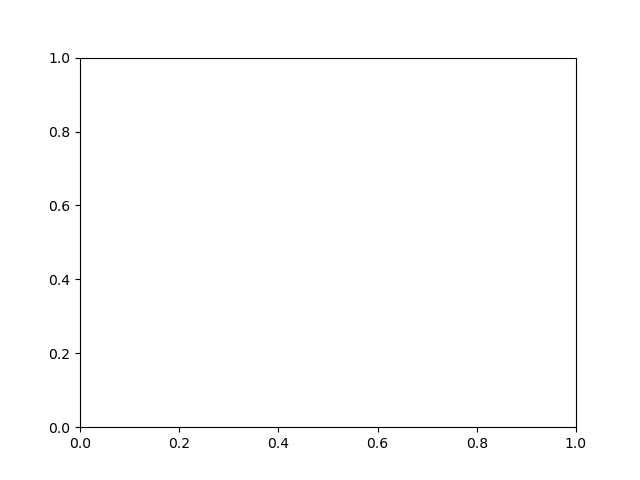

In [11]:
if "fittslaw_fig" in locals():
    plt.close(fittslaw_fig)
fittslaw_fig = plt.figure()
fittslaw_ax = fittslaw_fig.gca()
# fittslaw_fig, fittslaw_ax = plt.subplots(1, 2, figsize=[9, 3])

In [10]:

# position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
# position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
# position_series += data[f"episode_{EPISODE_ID}"]["target_position"][indices[1]-1] - position_series[indices[1]-1] #ensure that target is reached at target hit/switch time

position_series[10], data[f"episode_{EPISODE_ID}"]["target_position"][10]

(array([ 0.00965547, -0.25974968,  0.33524972]),
 array([ 0.5       , -0.24653858,  0.59395477]))

In [8]:
# Compute Minjerk trajectory as reference trajectory
def minimumjerk_deterministic(N, T, initialuservalues, dim, P, dt, x0, final_vel=None, final_acc=None, passage_times=None):
    if x0 is None:
        x0 = np.hstack((np.mean(np.squeeze(initialuservalues), axis=0), T[0]))

    if passage_times is None:
        passage_times = np.linspace(0, N, P).astype(
            int)  # WARNING: here: equally distributed target passage times!
    # else:
    #     passage_times = np.insert(passage_times, 0, 0)  #assume that argument "passage_times" had P - 1 values, as first "target switch" (i.e., from initial position to first real target) is fixed

    assert len(passage_times) == P

    n = dim * (3 + P)  # dimension of state vector (incorporating position, velocity, acceleration and "via-points" T)

    assert P == 2
    N_minjerk = np.ceil(passage_times[1]).astype(int)
    
    if final_vel is None:  #only used in VARIANT 2
        final_vel = np.zeros((dim,))
    if final_acc is None:  #only used in VARIANT 2
        final_acc = np.zeros((dim,))
    assert final_vel.shape == (dim,)
    assert final_acc.shape == (dim,)
        
#     ### VARIANT 1:  (this variant terminates with zero velocity and acceleration, independent of "final_vel" and "final_acc"!)
#     ## (Online) Control Algorithm
    
#     A = [None] * (N_minjerk)
#     B = [None] * (N_minjerk)
    
#     x = np.zeros((N + 1, n))
#     u = np.zeros((N, dim))

#     x[0] = x0
#     for i in range(0, N_minjerk):
#         u[i] = T[0][1*dim:]

#         ### COMPUTE time-dependent system matrices (with time relexation due to usage of passage_times[1] instead of int(passage_times[1]); for stochastic wrapper, see minjerk_get_all_timedependent_system_matrices()):
#         movement_time = (passage_times[1] - i) * dt
#         A_continuous = np.vstack(
#             (np.hstack((np.zeros(shape=(dim, dim)), np.eye(dim), np.zeros(shape=(dim, (P + 1) * dim)))),
#              np.hstack((np.zeros(shape=(dim, 2 * dim)), np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.hstack(((-60 / (movement_time ** 3)) * np.eye(dim), (-36 / (movement_time ** 2)) * np.eye(dim),
#                         (-9 / movement_time) * np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.zeros(shape=(P * dim, (P + 3) * dim))))
#         B_continuous = np.vstack((np.zeros(shape=(2 * dim, dim)),
#                                   (60 / (movement_time ** 3)) * np.eye(dim), np.zeros(shape=(P * dim, dim))))
#         # using explicit solution formula:
#         A[i] = expm(A_continuous * dt)
#         B[i] = np.linalg.pinv(A_continuous).dot(A[i] - np.eye((3 + P) * dim)).dot(B_continuous)
#         # B[i] = np.vstack((np.linalg.inv(A_continuous[:3*dim, :3*dim]).dot(A[i][:3*dim, :3*dim] - np.eye(3 * dim)).dot(B_continuous[:3*dim]),
#         #                     np.zeros(shape=(P * dim, dim))))
#         ############################################

#         x[i + 1] = A[i].dot(x[i]) + B[i].dot(u[i])

#     for i in range(N_minjerk, N):  # extend trajectory with constant last value
#         u[i] = T[0][1*dim:]
#         x[i + 1] = x[i] * np.repeat(np.array([1, 0, 0, 1, 1]), dim)

    ### VARIANT 2:
    # Explicit Solution Formula (current implementation only yields position time series!)
    t_f = passage_times[1] * dt
    #compute MinJerk trajectory per dimension
    
    #SHORT CODE:
    coeff_vec = np.array([[x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
                       -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
                       15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
                       -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]] for i in range(dim)] + 
                    [[x0[1*dim + i], t_f * x0[2*dim + i],
                       (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                       (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                       (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0] for i in range(dim)] +
                    [[x0[2*dim + i],
                   (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
                   (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
                   (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]), 0, 0] for i in range(dim)])
    x = np.squeeze([coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)])
    #LONG CODE:
    # x = []
    # for i in range(dim):  #position
    #     coeff_vec = np.array([x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
    #                        -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i],
    #                        15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i],
    #                        -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #velocity
    #     coeff_vec = np.array([x0[1*dim + i], t_f * x0[2*dim + i],
    #                        (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(5)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #acceleration
    #     coeff_vec = np.array([x0[2*dim + i],
    #                        (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i] - 4 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i]),
    #                        (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i] + 7 * t_f * final_vel[i] - 1 * (t_f ** 2) * final_acc[i]),
    #                        (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i] - 3 * t_f * final_vel[i] + 0.5 * (t_f ** 2) * final_acc[i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(4)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # x = np.array(x).T
    
    if N > N_minjerk:
        x = np.concatenate((x, [x[-1]] * (N - N_minjerk)))
    u = None  #[T[0][1*dim:]] * (N_minjerk + 1)

    return x, u



In [9]:
x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
x_minjerk, u_minjerk

(array([[ 1.13697223e-02, -2.88931404e-01,  3.37144104e-01,
          1.25629739e-02, -7.07790465e-03,  1.37616261e-03,
         -9.29245726e+00,  1.37363738e+00, -5.91205869e-01],
        [ 1.53327467e-02, -2.88585530e-01,  3.39333896e-01,
          1.14160471e+00,  1.05339644e-01,  6.21628759e-01,
          2.08240116e+02,  1.88756842e+01,  1.10745424e+02],
        [ 3.89254721e-02, -2.86451316e-01,  3.51980585e-01,
          3.69964105e+00,  3.30744258e-01,  1.96922676e+00,
          2.82455415e+02,  2.44702745e+01,  1.47964690e+02],
        [ 8.98668759e-02, -2.81944342e-01,  3.78960440e-01,
          6.43196776e+00,  5.65038097e-01,  3.39560096e+00,
          2.49047140e+02,  2.11527535e+01,  1.29587477e+02],
        [ 1.65113578e-01, -2.75371399e-01,  4.18590078e-01,
          8.44081760e+00,  7.34076775e-01,  4.43739099e+00,
          1.43708991e+02,  1.19184667e+01,  7.41346713e+01],
        [ 2.54429211e-01, -2.67630955e-01,  4.65478562e-01,
          9.18536034e+00,  7.936693